<span style="color: #8f3b43; font-size: 35px; font-weight: bold; display: inline-flex; align-items: center;">
  Text Sentiment Analysis using RNN and LSTM
  <img src="https://cdn.jsdelivr.net/npm/simple-icons@v9/icons/dialogflow.svg" alt="NLP Icon" style="height: 35px; margin-left: 10px;">
</span>


In [84]:
# Data & Preprocessing Libraries
import pandas as pd
import numpy as np
import re
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Tokenization & Text Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Label Encoding & Train-Test Split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Deep Learning (Keras/TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, 
    SimpleRNN, 
    Bidirectional, 
    LSTM, 
    GRU, 
    Dense, 
    Dropout, 
    BatchNormalization, 
    SpatialDropout1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# NLTK Downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [48]:
import pandas as pd
df = pd.read_csv("train.csv", encoding='ISO-8859-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [49]:
df.head(10)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929,440.0,223
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774,2736690.0,17
7,50e14c0bb8,Soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243,28470.0,104
8,e050245fbd,Both of you,Both of you,neutral,night,31-45,Australia,25499884,7682300.0,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398,82400.0,109


In [50]:
df['sentiment'] = df['sentiment'].str.strip()
sentiments = df['sentiment'].unique().tolist()
print(sentiments)

['neutral', 'negative', 'positive']


## 🧹 Define text preprocessing functions

- Create a function to clean text (lowercasing, removing URLs, mentions, hashtags, and special characters).
- Use emoji conversion to text.
- Remove stopwords but keep important pronouns (e.g., "I", "we", "you").
- Apply lemmatization to reduce words to their base form.


In [51]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = emoji.demojize(text)
    text = re.sub(r"[^a-zA-Z\s']", "", text)
    return text

stop_words = set(stopwords.words('english')) - {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself'}

def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

## Preview cleaned vs original text

In [52]:
print("Sample Before and After Cleaning:\n")
for i, row in df.head(5).iterrows():
    print(f"Original: {row['text']}")
    print(f"Cleaned : {preprocess_text(row['text'])}\n")

Sample Before and After Cleaning:

Original:  I`d have responded, if I were going
Cleaned : id responded i going

Original:  Sooo SAD I will miss you here in San Diego!!!
Cleaned : sooo sad i miss you san diego

Original: my boss is bullying me...
Cleaned : my bos bullying me

Original:  what interview! leave me alone
Cleaned : interview leave me alone

Original:  Sons of ****, why couldn`t they put them on the releases we already bought
Cleaned : son couldnt put release we already bought



## ✨ Apply preprocessing to dataset

- Drop rows with missing values in the 'text' column.
- Apply the text preprocessing function to the entire dataset.
- Store the cleaned text in a new column called 'clean_text'.

In [53]:
df = df.dropna(subset=['text'])
df['clean_text'] = df['text'].apply(preprocess_text)

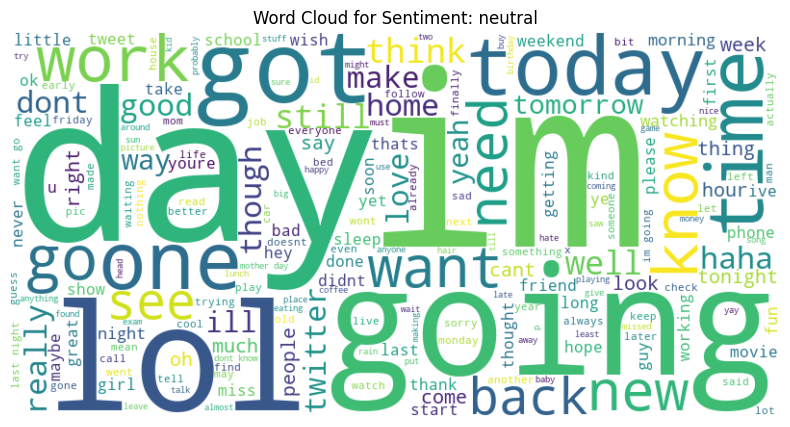

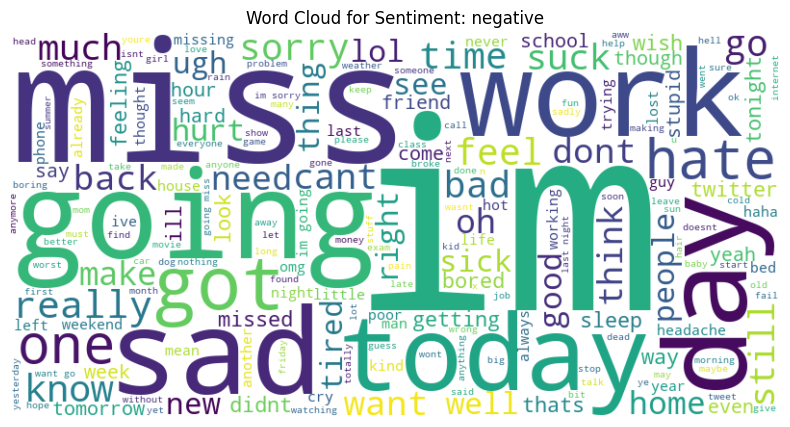

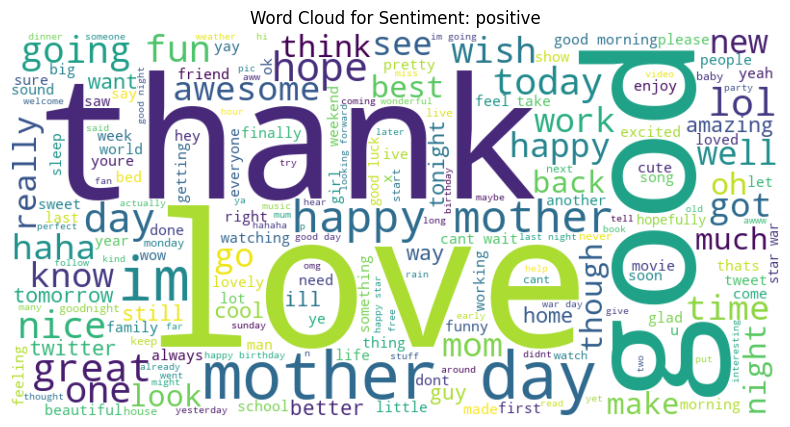

In [54]:
custom_sentiments = ['neutral', 'negative', 'positive']

def plot_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for sentiment in custom_sentiments:
    subset = df[df['sentiment'] == sentiment]
    if not subset.empty:
        plot_wordcloud(subset['clean_text'], f'Word Cloud for Sentiment: {sentiment}')
    else:
        print(f"No tweets found for sentiment: {sentiment}")

## 🧩 Convert text to sequences

- Initialize a Keras tokenizer with a vocabulary size limit.
- Fit the tokenizer on the cleaned text.
- Transform the text data into sequences of integers (token IDs).

In [55]:
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

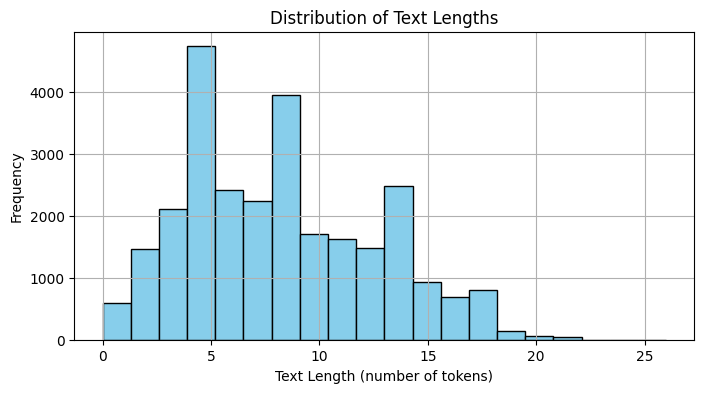

In [56]:
lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (number of tokens)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##  Pad sequences for modeling

- Define a max sequence length cap (e.g., 100 tokens).
- Apply padding and truncating to make all sequences the same length.
- Display shape and an example padded sequence to confirm results.

In [57]:
max_seq_len = max(lengths)
cap_len = 100

final_max_len = min(max_seq_len, cap_len)
print(f"\nMax tweet length in dataset: {max_seq_len}, Using max_len = {final_max_len}")

padded = pad_sequences(sequences, maxlen=final_max_len, padding='post', truncating='post')

print("Padded Sequences Shape:", padded.shape)
print("Example Padded Sequence:", padded[100])


Max tweet length in dataset: 26, Using max_len = 26
Padded Sequences Shape: (27480, 26)
Example Padded Sequence: [  2 459 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


### Encoding the Sentiment Labels
- Convert sentiment classes to numeric labels using LabelEncoder.
- One-hot encode these numeric labels to prepare for multi-class classification.
- Split the data into training (80%) and testing (20%) sets.

In [58]:
le = LabelEncoder()
df['Sentiment_Label'] = le.fit_transform(df['sentiment'])
labels = le.classes_.tolist()
y = pd.get_dummies(df['Sentiment_Label']).values
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=42)


### 🏗️ Simple RNN Model (Baseline)
- Start with a basic RNN layer to establish a performance baseline.
- This model is simpler and faster to train compared to LSTM/GRU.

In [ ]:
simple_rnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=final_max_len),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y.shape[1], activation='softmax')
])

simple_rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
simple_rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 26, 128)           3223936   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                      

In [78]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

simple_history = simple_rnn_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


687/687 [==============================] - 27s 38ms/step - loss: 1.1743 - accuracy: 0.3719 - val_loss: 1.0794 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 2/10
687/687 [==============================] - 25s 36ms/step - loss: 1.0388 - accuracy: 0.4602 - val_loss: 0.9878 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 3/10
687/687 [==============================] - 21s 31ms/step - loss: 0.9774 - accuracy: 0.5068 - val_loss: 0.9646 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 4/10
687/687 [==============================] - 20s 29ms/step - loss: 0.9312 - accuracy: 0.5360 - val_loss: 0.9934 - val_accuracy: 0.5113 - lr: 0.0010
Epoch 5/10
687/687 [==============================] - 24s 34ms/step - loss: 0.8913 - accuracy: 0.5621 - val_loss: 0.9611 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 6/10
687/687 [==============================] - 22s 32ms/step - loss: 0.8899 - accuracy: 0.5703 - val_loss: 1.0063 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 7/10
686/687 [============================>.] - ETA: 0s - loss:

In [ ]:
simple_preds = simple_rnn_model.predict(X_test)
simple_preds_classes = np.argmax(simple_preds, axis=1)
true_classes_simple = np.argmax(y_test, axis=1)

print(classification_report(true_classes_simple, simple_preds_classes, target_names=labels))

172/172 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    negative       0.76      0.49      0.60      1572
     neutral       0.62      0.71      0.66      2236
    positive       0.69      0.78      0.73      1688

    accuracy                           0.67      5496
   macro avg       0.69      0.66      0.66      5496
weighted avg       0.68      0.67      0.66      5496



### 🏗️ Building a Hybrid RNN Model (LSTM + GRU)
- Embedding layer to convert tokens to dense vectors.
- Bi-directional LSTM followed by GRU for deep sequence learning.
- Batch normalization and dropout to prevent overfitting.

In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=final_max_len),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    BatchNormalization(),
    GRU(16, dropout=0.2, recurrent_dropout=0.2),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 26, 128)           3223936   
                                                                 
 bidirectional_4 (Bidirectio  (None, 26, 128)          98816     
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 26, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 26, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 32)                15552     
                                                                 
 dense_10 (Dense)            (None, 32)               

In [75]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


687/687 [==============================] - 46s 56ms/step - loss: 0.9632 - accuracy: 0.5153 - val_loss: 0.8093 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 2/10
687/687 [==============================] - 38s 55ms/step - loss: 0.6812 - accuracy: 0.7277 - val_loss: 0.6982 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 3/10
687/687 [==============================] - 39s 57ms/step - loss: 0.5577 - accuracy: 0.7830 - val_loss: 0.7821 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 4/10
687/687 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8185
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
687/687 [==============================] - 38s 55ms/step - loss: 0.4727 - accuracy: 0.8185 - val_loss: 0.8471 - val_accuracy: 0.6779 - lr: 0.0010
Epoch 5/10
687/687 [==============================] - 40s 59ms/step - loss: 0.3642 - accuracy: 0.8664 - val_loss: 0.9778 - val_accuracy: 0.6860 - lr: 5.0000e-04
